In [ ]:
!pip install kaggle

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import measure
from tqdm import tqdm
import random
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d hamdallak/the-iqothnccd-lung-cancer-dataset

 97% 145M/149M [00:01<00:00, 73.5MB/s]
100% 149M/149M [00:01<00:00, 90.7MB/s]


In [ ]:
! unzip the-iqothnccd-lung-cancer-dataset.zip

Archive:  the-iqothnccd-lung-cancer-dataset.zip
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (1).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (10).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (100).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (101).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (102).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (103).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (104).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (105).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (106).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (107).jpg  
  inflating: The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (108).jpg  
  inflating: The IQ-

In [ ]:
dataRoot = "/content/The IQ-OTHNCCD lung cancer dataset/"

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
model = tf.keras.models.load_model("/content/gdrive/MyDrive/Training_logs/UNet_best_Model_checkpoint.h5", custom_objects={'dice_coef':dice_coef, 'dice_coef_loss':dice_coef_loss})
model2 = tf.keras.models.load_model("/content/gdrive/MyDrive/Training_logs/best_checkpoint_model2.h5")

In [ ]:
mfiles = os.listdir(dataRoot+"Malignant cases/")
random.shuffle(mfiles)
mfiles = mfiles[:30]
bfiles = os.listdir(dataRoot+"Bengin cases/")
random.shuffle(bfiles)
bfiles = bfiles[:30]
nfiles = os.listdir(dataRoot+"Normal cases/")
random.shuffle(nfiles)
nfiles = nfiles[:30]

In [ ]:
def preprocess(img):
    if img.max()>255 or img.max()<1.5 or img.min()<0:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (512,512))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_improved = clahe.apply(img.astype(np.uint8))
    # img_improved = img.copy()
    centeral_area = img[100:400, 100:400]
    kmeans = KMeans(n_clusters=2).fit(np.reshape(centeral_area, [np.prod(centeral_area.shape), 1]))
    centroids = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centroids)
    ret, lung_roi = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY_INV)
    lung_roi = cv2.erode(lung_roi, kernel=np.ones([4,4]))
    lung_roi = cv2.dilate(lung_roi, kernel=np.ones([13,13]))
    lung_roi = cv2.erode(lung_roi, kernel=np.ones([8,8]))

    labels = measure.label(lung_roi)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0] < 500 and B[3]-B[1] < 490 and B[0] > 17 and B[2] < 495:
            good_labels.append(prop.label)
    lung_roi_mask = np.zeros_like(labels)
    for N in good_labels:
        lung_roi_mask = lung_roi_mask + np.where(labels == N, 1, 0)

    contours, hirearchy = cv2.findContours(lung_roi_mask,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    external_contours = np.zeros(lung_roi_mask.shape)
    for i in range(len(contours)):
        if hirearchy[0][i][3] == -1:  #External Contours
            area = cv2.contourArea(contours[i])
            if area>518.0:
                cv2.drawContours(external_contours,contours,i,(1,1,1),-1)
    external_contours = cv2.dilate(external_contours, kernel=np.ones([4,4]))

    external_contours = cv2.bitwise_not(external_contours.astype(np.uint8))
    external_contours = cv2.erode(external_contours, kernel=np.ones((7,7)))
    external_contours = cv2.bitwise_not(external_contours)
    external_contours = cv2.dilate(external_contours, kernel=np.ones((12,12)))
    external_contours = cv2.erode(external_contours, kernel=np.ones((12,12)))

    contours, hirearchy = cv2.findContours(external_contours,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    external_contours2 = np.zeros(external_contours.shape)
    for i in range(len(contours)):
        if hirearchy[0][i][3] == -1:  #External Contours
            area = cv2.contourArea(contours[i])
            if area>518.0:
                cv2.drawContours(external_contours2,contours,i,(1,1,1),-1)

    img_improved = img_improved.astype(np.uint8)
    external_contours2 = external_contours2.astype(np.uint8)
    extracted_lungs = cv2.bitwise_and(img_improved, img_improved, mask=external_contours2)

    return ((extracted_lungs-127.0)/127.0).astype(np.float32)

In [ ]:
def display(imgs,mask):
    j = 1
    for im,mk in zip(imgs,mask):
      plt.figure(figsize=(20,300))
      plt.subplot(50,3,j)
      plt.imshow(np.squeeze(im), cmap="gray")
      plt.subplot(50,3,j+1)
      plt.imshow(np.squeeze(mk), cmap="gray")
      plt.subplot(50,3,j+2)
      plt.imshow(cv2.addWeighted(np.squeeze(im), .5, np.squeeze(mk), .5, 0), cmap="gray")
      j += 3

In [ ]:
def display2(imgs, titles=None, cmap="bone"):
    n = len(list(imgs))
    r = n//3 if n%3==0 else (n//3)+1
    plt.figure(figsize=(25,int(8*r)))
    for i,img in enumerate(imgs):
        plt.subplot(r,3,i+1)
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(img, cmap=cmap)

In [ ]:
def display_test(img, cmap='bone'):
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap=cmap)

In [ ]:
originals = []
mimgs = []
bimgs = []
nimgs = []

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for m in tqdm(mfiles):
    img = cv2.imread(dataRoot+"Malignant cases/"+m, 0)
    originals.append(clahe.apply(cv2.resize(img, (512,512)).astype(np.uint8)))
    img = preprocess(img)
    mimgs.append(img)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  3%|▎         | 1/30 [00:00<00:09,  3.21it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  7%|▋         | 2/30 [00:01<00:20,  1.40it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 10%|█         | 3/30 [00:02<00:19,  1.39it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will cha

In [ ]:
mi = np.array(mimgs)
pred = model.predict(np.reshape(mi,(len(mi),512,512,1)))
pred[pred>=0.5] = 255
pred[pred<0.5] = 0
pred = pred.astype(np.uint8)
pred = list(pred)
mpred = [np.squeeze(i) for i in pred]

1/1 [==============================] - 76s 76s/step


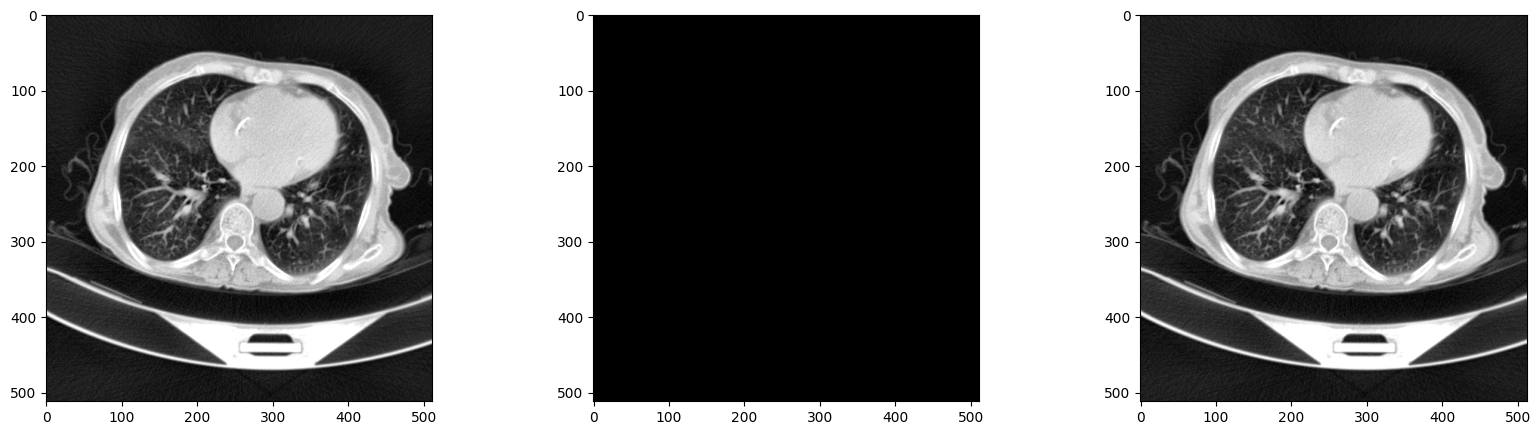

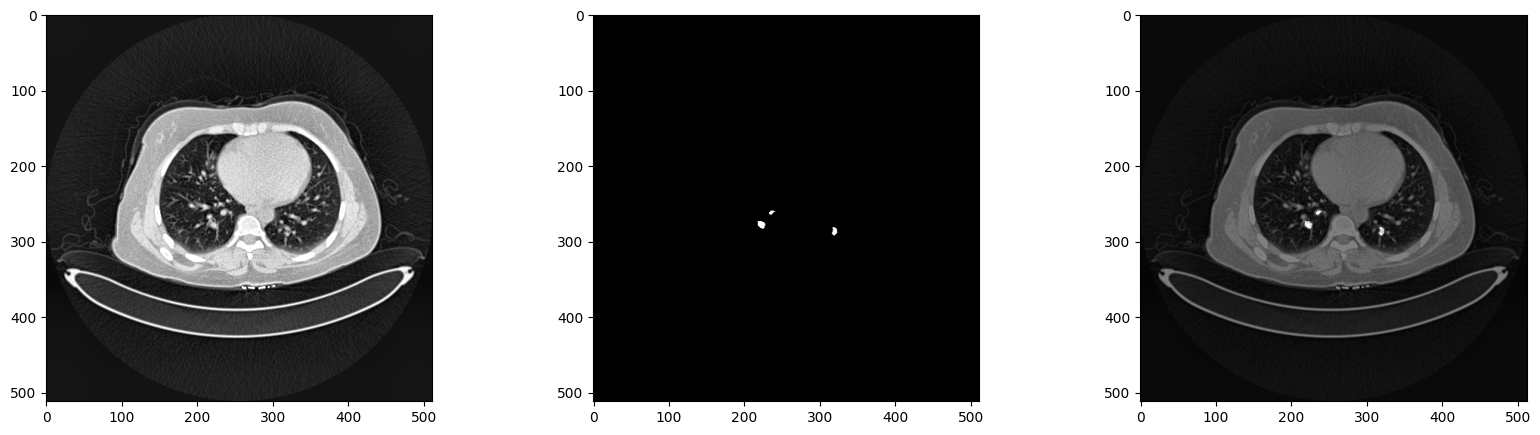

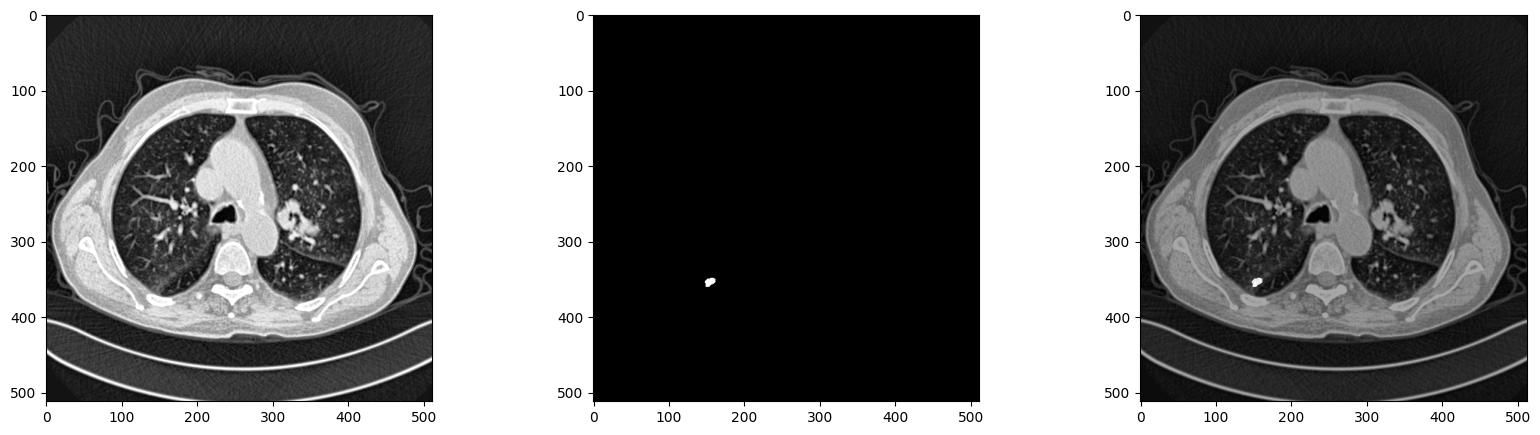

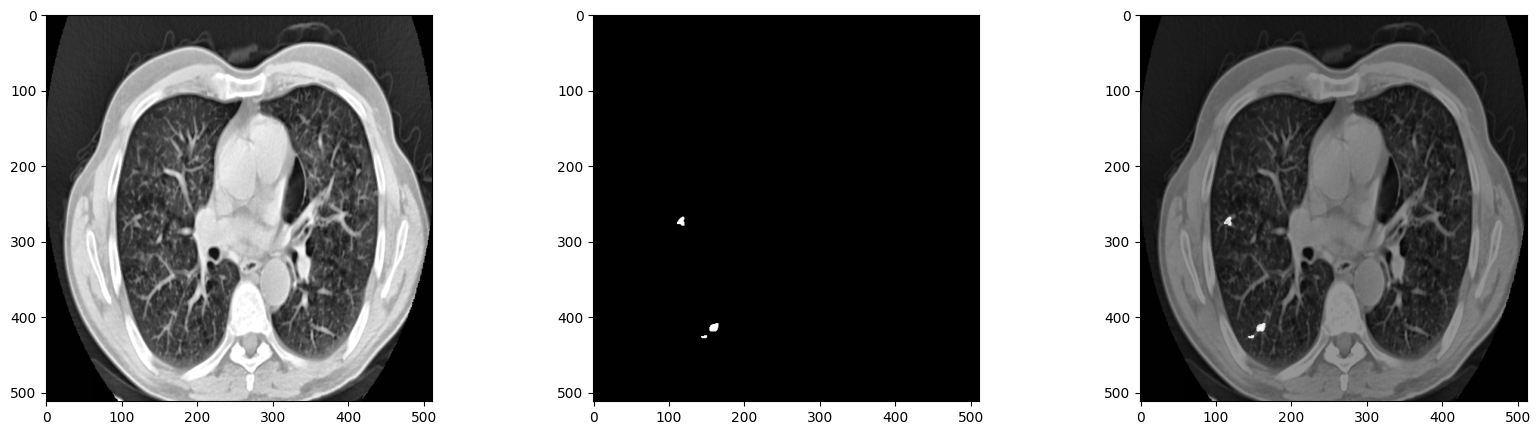

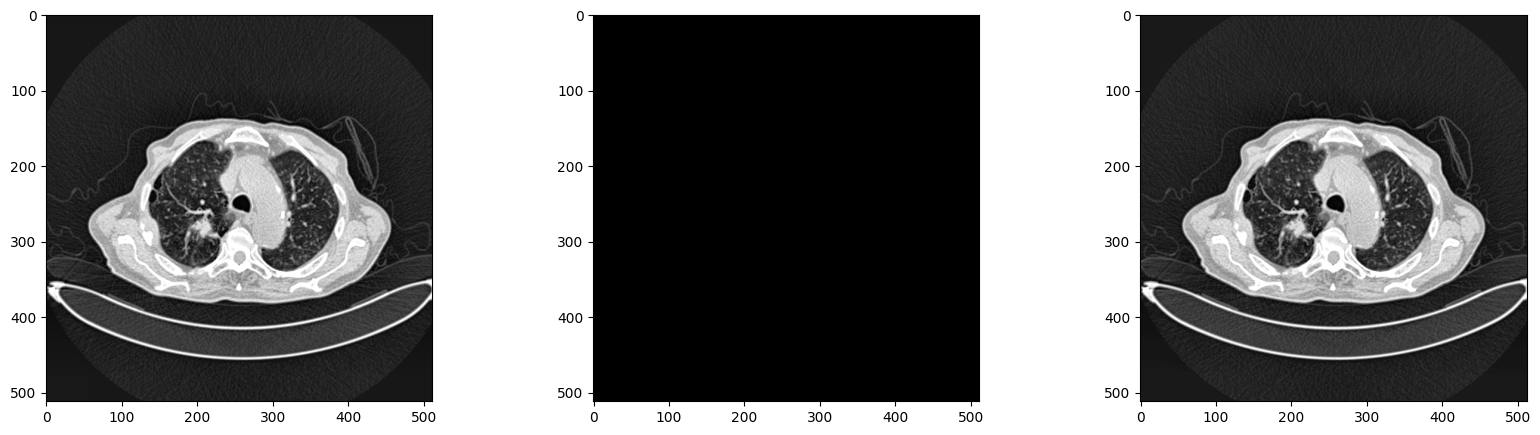

In [ ]:
display(originals[10:15],mpred[10:15])


In [ ]:
bboxes = []
for mask in mpred:
    mask = cv2.dilate(mask, kernel=np.ones((5,5)))
    labels = measure.label(mask)
    regions = measure.regionprops(labels)
    bb = []
    for prop in regions:
        B = prop.bbox
        bb.append((( max(0, B[1]-10), max(0, B[0]-10) ),( min(B[3]+10, 512), min(B[2]+10, 512) )))    # ((x1,y1),(x2,y2))
    bboxes.append(bb)

In [ ]:
bboxes[1]


[((192, 144), (219, 171)), ((104, 278), (131, 305)), ((137, 338), (165, 366))]

In [ ]:
bs = []
o = copy.deepcopy(mimgs)
for i,(img,boxes) in enumerate(zip(o,bboxes)):
    for rect in boxes:
        cv2.rectangle(img, rect[0], rect[1], (1), 2)

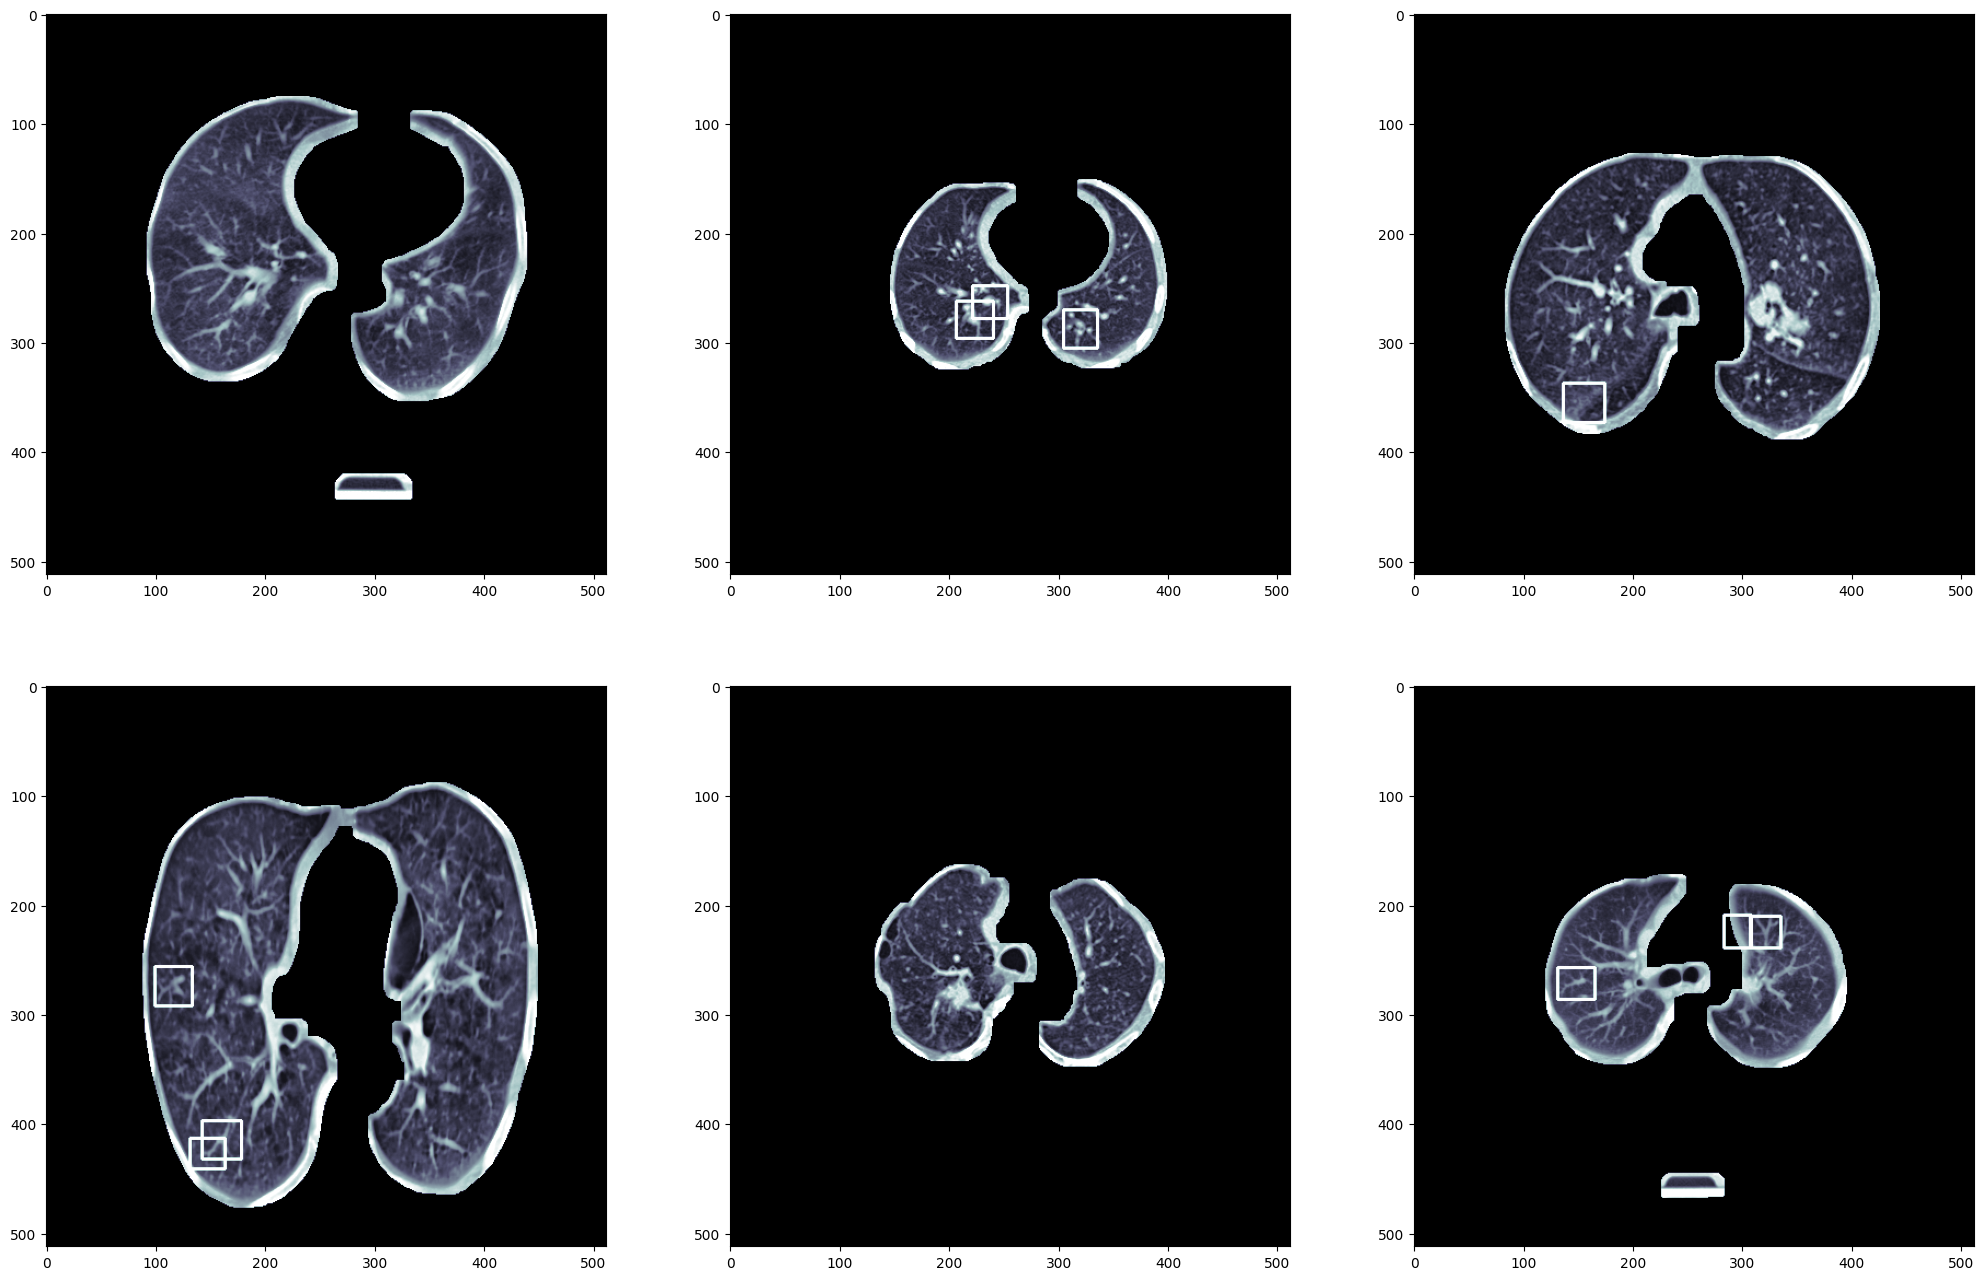

In [ ]:
display2(o[10:16])


In [ ]:
o2 = copy.deepcopy(originals)
final_boxes = []
for i,(img,bbox) in enumerate(zip(o2, bboxes)):
    img_boxes = []
    for box in bbox:
        x1 = box[0][0]
        y1 = box[0][1]
        x2 = box[1][0]
        y2 = box[1][1]
        if abs(x1-x2) <=50 or abs(y1-y2)<=50:
            x = (x1+x2)//2
            y = (y1+y2)//2
            x1 = max(x-25, 0)
            x2 = min(x+25, 512)
            y1 = max(y-25, 0)
            y2 = min(y+25, 512)
            imgbox = img[y1:y2,x1:x2]
            img_boxes.append(imgbox)
        else:
            imgbox = img[y1:y2,x1:x2]
            img_boxes.append(imgbox)
    final_boxes.append(img_boxes)

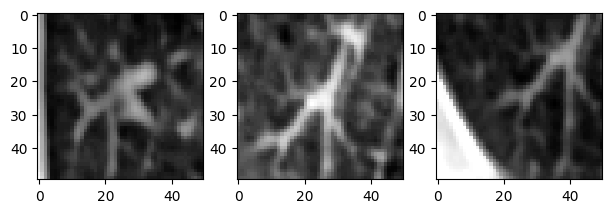

In [ ]:
plt.figure(figsize=(15,15))
for i,img in enumerate(final_boxes[13]):
    plt.subplot(1,6,i+1)
    plt.imshow(img, cmap="gray")

In [ ]:
predictions = []
for i in final_boxes:
    each_p = []
    for img in i:
        if img.shape != (50,50):
            img = np.resize(img, (50,50))
        img = img/255.
        img = np.reshape(img, (1,50,50,1))
        pred = model2.predict(img)
        pred = pred>=0.5
        each_p.append(1)
    predictions.append(each_p)

1/1 [==============================] - 0s 45ms/step


In [ ]:
final_img_bbox = []
cancer = []
for i,(img,bbox,preds) in enumerate(zip(mimgs, bboxes, predictions)):
    token = False
    for box,pred in zip(bbox,preds):
        if pred:
            x1 = box[0][0]
            y1 = box[0][1]
            x2 = box[1][0]
            y2 = box[1][1]
            img = cv2.rectangle(img, (x1,y1), (x2,y2), (2), 2)
            token = True
    final_img_bbox.append(img)
    cancer.append(token)

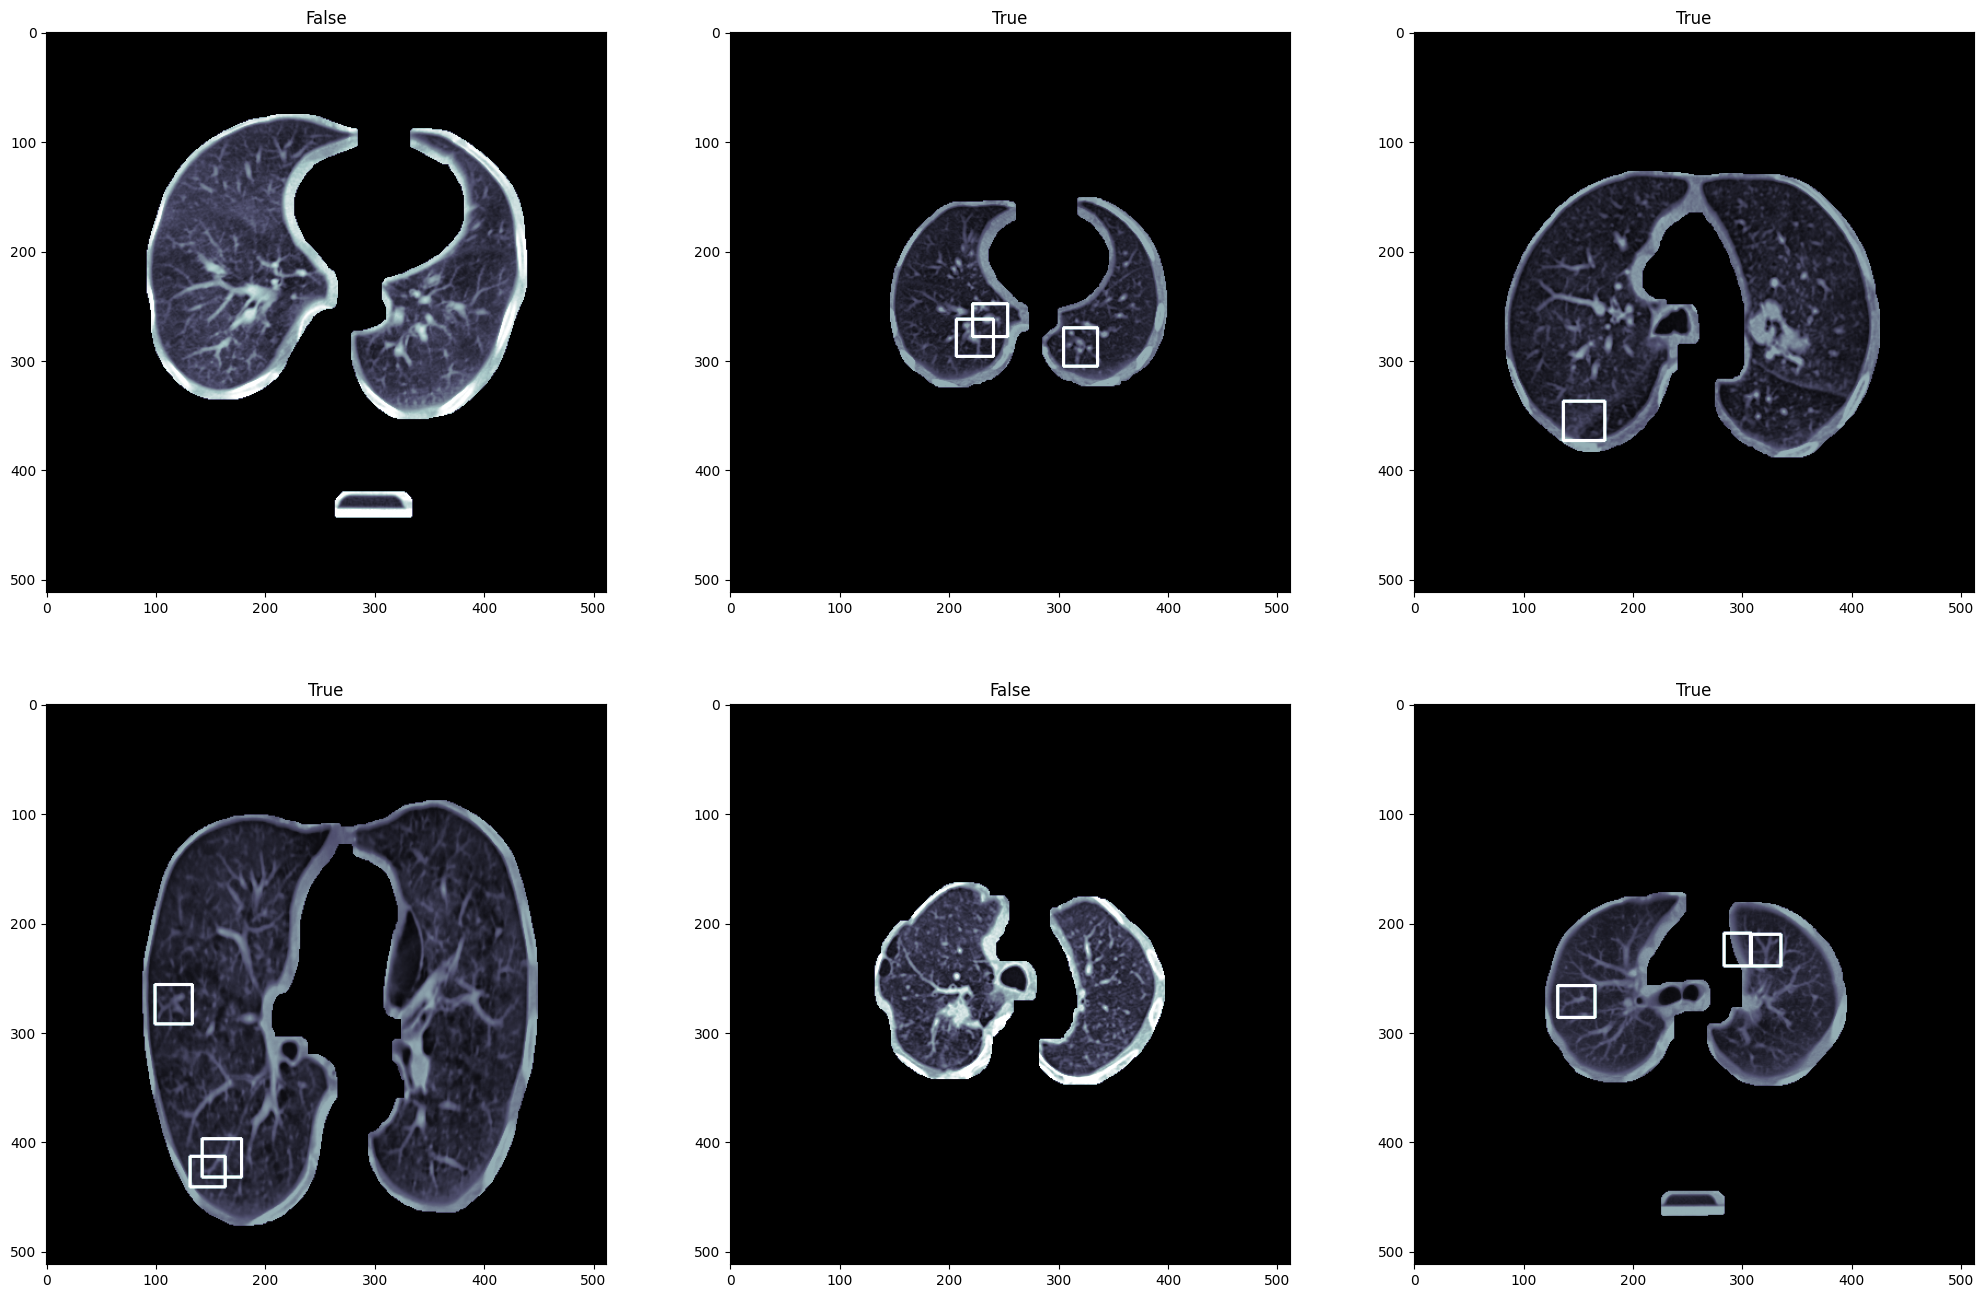

In [ ]:
display2(final_img_bbox[10:16], cancer[10:16])
